In [1]:
import pandas as pd 
import numpy as np
from collections import  OrderedDict
from copy import deepcopy
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rc
plt.rcParams.update({"text.usetex": True})
plt.rcParams['font.family']='sans-serif'

# Check dual dimension

In [2]:
import sys
sys.path.append("../../")
import src.utils as utils

In [3]:
lifted_dimension_dict = {}
for p in [123, 1355191, 47236, 20958, 300]:
    print(f"===== p:{p} ======")
    lifted_dimension_lst = []
    for grp_size in [10, 100]:
         for overlap_ratio in [0.1, 0.2, 0.3]:    
            group = utils.gen_chain_group(dim=p, grp_size=grp_size, grp_size_ratio=None, overlap_ratio=overlap_ratio)
            groups = group['groups']
            lifted_dimension = 0
            for (i, g) in enumerate(groups):
                lifted_dimension += len(g)
            lifted_dimension_lst.append(lifted_dimension)
    lifted_dimension_dict[p] = lifted_dimension_lst
    print(lifted_dimension_dict[p])

===== p:123 ======
[136, 153, 174, 133, 143, 153]
===== p:1355191 ======
[1505767, 1693987, 1935985, 1505761, 1693971, 1935961]
===== p:47236 ======
[52484, 59044, 67477, 52476, 59036, 67456]
===== p:20958 ======
[23286, 26196, 29937, 23278, 26178, 29898]
===== p:300 ======
[333, 374, 426, 330, 360, 390]


In [4]:
for p,v in lifted_dimension_dict.items():
    print(p, min(v), max(v))

123 133 174
1355191 1505761 1935985
47236 52476 67477
20958 23278 29937
300 330 426


# Collect Results

In [5]:
def gen_path(solver, regularizer, actual_seed, dataset, lam_shrink, chain_grpsize, chain_overlap_ratio,
             purpose='logit_chain/details', loss='logit', task='chain', **kwargs):
    task_hypers_template = {
                    'ProxSAGA': OrderedDict({ 'ipg_strategy': 'diminishing', 'seed':None, 'proxsaga_lipcoef': 1.0,}),
                    'ProxSVRG': OrderedDict({ 'ipg_strategy': 'diminishing', 'seed':None, 'proxsvrg_inner_repeat': 1, 'proxsvrg_lipcoef': 1.0}),
                    'PStorm':   OrderedDict({ 'ipg_strategy': 'diminishing', 'seed':None,'pstorm_stepsize': 'diminishing', 'pstorm_betak': -1.0, 'pstorm_lipcoef': 1.0}),
                    'RDA':      OrderedDict({ 'ipg_strategy': 'diminishing', 'seed':None, 'rda_stepconst': 0.01}),
                    'SPStorm':  OrderedDict({ 'ipg_strategy': 'diminishing', 'seed':None, 'spstorm_betak': -1.0, 'spstorm_zeta': 'dynanmic', 'spstorm_lipcoef': 1.0})
                }
    solver_hyper = task_hypers_template[solver]
    solver_hyper['seed'] = actual_seed
    for k in kwargs:
        if k in task_hypers_template:
            kwargs[k] = v
    path = f'../{purpose}/{solver}_{loss}_{regularizer}/{dataset}_lam_shrink:{lam_shrink}_{task}_{chain_grpsize}_{chain_overlap_ratio}'
    for k,v in solver_hyper.items():
        if k == 'ipg_strategy':
            path += f'_{v}'
        else:
            path += f'_{k}:{v}'
    path += '_stats.npy'
    return path

In [6]:
# solver = 'ProxSVRG'
# path = gen_path(solver, regularizer='NatOG', actual_seed=2023, dataset='a9a', lam_shrink=0.1, chain_grpsize=10, chain_overlap_ratio=0.1)
# np.load(path,  allow_pickle=True).item().keys()

In [7]:
def create_df(seed_lst, 
              datasets=["a9a", 'rcv1', 'real-sim', 'news20', "w8a"], 
              lam_shrink_lst=[1e-1, 1e-2], 
              chain_grpsize_lst=[10,100], 
              chain_overlap_ratio_lst=[0.1,0.2,0.3], 
              solvers=["ProxSVRG", "ProxSAGA", "RDA", "PStorm", "SPStorm"], max_epoch = 500):
    df_dict = {'problem_id':[]}
    for solver in solvers:
        df_dict[f"{solver}_best_F"] = []
        df_dict[f"{solver}_best_F_std"] = []        
        df_dict[f"{solver}_best_Fs_nz"] = []
        df_dict[f"{solver}_best_Fs_nz_std"] = []
        df_dict[f"{solver}_last_nz"] = []
        df_dict[f"{solver}_last_nz_std"] = []  
    for dataset in datasets:
        for lam_shrink in lam_shrink_lst:
            for chain_grpsize in chain_grpsize_lst:
                for chain_overlap_ratio in chain_overlap_ratio_lst:
                    problem_id = f"{dataset}_{lam_shrink}_{chain_grpsize}_{chain_overlap_ratio}"
                    df_dict['problem_id'].append(problem_id)     
                    for solver in solvers:
                        best_F_lst = []
                        best_Fs_nz_lst = []
                        last_nz_lst = []
                        for actual_seed in seed_lst:
                            try:
                                filename = gen_path(solver, regularizer='NatOG', actual_seed=actual_seed, dataset=dataset, 
                                                    lam_shrink=lam_shrink, chain_grpsize=chain_grpsize, chain_overlap_ratio=chain_overlap_ratio)
                                info = np.load(filename,  allow_pickle=True).item()
                            except FileNotFoundError:
                                info = None
                            if info is not None:
                                F_seq = np.array(info['F_seq'])
                                nz_seq = np.array(info['nz_seq'])
                                if solver == "ProxSVRG":
                                    F_seq = F_seq[:max_epoch+1]
                                    nz_seq = nz_seq[:max_epoch+1]
                            else:
                                # no result
                                F_seq = np.array([np.nan])
                                nz_seq = np.array([np.nan])

                            best_F_lst.append(np.min(F_seq))
                            best_Fs_nz_lst.append(nz_seq[np.argmin(F_seq.reshape(-1))])
                            last_nz_lst.append(nz_seq[-1])
                        # end of the for loop for seed_lst
                        df_dict[f"{solver}_best_F"].append(np.mean(best_F_lst))
                        df_dict[f"{solver}_best_F_std"].append(np.std(best_F_lst))
                        df_dict[f"{solver}_best_Fs_nz"].append(np.mean(best_Fs_nz_lst))
                        df_dict[f"{solver}_best_Fs_nz_std"].append(np.std(best_Fs_nz_lst))
                        df_dict[f"{solver}_last_nz"].append(np.mean(last_nz_lst))
                        df_dict[f"{solver}_last_nz_std"].append(np.std(last_nz_lst))                        
    return pd.DataFrame.from_dict(df_dict)    

In [8]:
df = create_df(seed_lst=[2023], max_epoch = 500)
# df[['problem_id', 'ProxSAGA_last_nz']]

In [9]:
# compute the best_F per instance
datasets=["a9a", 'rcv1', 'real-sim', 'news20', "w8a"]
lam_shrink_lst=[1e-1, 1e-2]
chain_grpsize_lst=[10,100] 
chain_overlap_ratio_lst=[0.1,0.2,0.3]
solvers=["ProxSVRG", "ProxSAGA", "RDA", "PStorm", "SPStorm"]
cols = []
for solver in solvers:
    cols.append(f"{solver}_best_F")
df_Fbest = df[['problem_id']+cols]
df_Fbest_mat=df_Fbest[cols].to_numpy()
cols = []
for solver in solvers:
    cols.append(f"{solver}_best_Fs_nz")
df_Fbests_nz = df[['problem_id']+cols]
df_Fbests_nz_mat=df_Fbests_nz[cols].to_numpy()

In [10]:
nz_gt = []
selected_id_lst = []
for row_id in range(df_Fbest_mat.shape[0]):
    row = df_Fbest_mat[row_id]
    min_id = np.nanargmin(row)
    Fmin = row[min_id]
    candidate_lst = [min_id]
    for i in range(5):
        if i != min_id and np.abs(row[i] - Fmin) <= 1e-6:
            candidate_lst.append(i)
    nz_lst = []
    for selected_id in candidate_lst:
        nz_lst.append(df_Fbests_nz_mat[row_id][selected_id])
    nz_gt.append(max(nz_lst))
    selected_id_lst.append(candidate_lst[np.argmax(nz_lst)])
nz_gt = np.array(nz_gt)
# selected_idx = np.nanargmin(df_Fbest_mat, axis=1,)
# nz_gt = df_Fbests_nz_mat[np.arange(df_Fbests_nz_mat.shape[0]), selected_id_lst]
F_gt = df_Fbest_mat[np.arange(df_Fbest_mat.shape[0]), selected_id_lst]

In [11]:
# selected_id_lst
selected_solver_per_instance_dict = {}
for instance_name, solver_id in zip(df_Fbests_nz['problem_id'].to_list(), selected_id_lst):
    selected_solver_per_instance_dict[instance_name] = solver_id

In [12]:
gt_dict = {}
for idx, instance in enumerate(df_Fbests_nz['problem_id'].to_list()):
    gt_dict[instance] = {'nz_gt':nz_gt[idx], 'F_gt':F_gt[idx]}

In [13]:
def create_df_enhance(gt_dict, seed_lst, 
              datasets=["a9a", 'rcv1', 'real-sim', 'news20', "w8a"], 
              lam_shrink_lst=[1e-1, 1e-2], 
              chain_grpsize_lst=[10,100], 
              chain_overlap_ratio_lst=[0.1,0.2,0.3], 
              solvers=["ProxSVRG", "ProxSAGA", "RDA", "PStorm", "SPStorm"], max_epoch = 500):
    df_dict = {'problem_id':[], 'F_gt':[], 'nz_gt':[]}
    for solver in solvers:
        df_dict[f"{solver}_best_F"] = []
        df_dict[f"{solver}_best_F_std"] = []        
        df_dict[f"{solver}_last_nz"] = []
        df_dict[f"{solver}_last_nz_std"] = []        
        df_dict[f"{solver}_first_id"] = []
        df_dict[f"{solver}_first_id_std"] = []        
        df_dict[f"{solver}_first_cst_id"] = []
        df_dict[f"{solver}_first_cst_id_std"] = []
        df_dict[f"{solver}_total_id"] = []
        df_dict[f"{solver}_total_id_std"] = []   
    for dataset in datasets:
        for lam_shrink in lam_shrink_lst:
            for chain_grpsize in chain_grpsize_lst:
                for chain_overlap_ratio in chain_overlap_ratio_lst:
                    problem_id = f"{dataset}_{lam_shrink}_{chain_grpsize}_{chain_overlap_ratio}"
                    df_dict['problem_id'].append(problem_id)     
                    nz_gt = gt_dict[problem_id]['nz_gt']
                    F_gt = gt_dict[problem_id]['F_gt']
                    df_dict['F_gt'].append(F_gt)
                    df_dict['nz_gt'].append(nz_gt)                      
                    for solver in solvers:
                        best_F_lst = []
                        last_nz_lst = []
                        first_id_lst = []
                        first_consistent_id_lst = []
                        total_id_lst = []
                        for actual_seed in seed_lst:
                            try:
                                filename = gen_path(solver, regularizer='NatOG', actual_seed=actual_seed, dataset=dataset, 
                                                    lam_shrink=lam_shrink, chain_grpsize=chain_grpsize, chain_overlap_ratio=chain_overlap_ratio)
                                info = np.load(filename,  allow_pickle=True).item()
                            except FileNotFoundError:
                                info = None
                            if info is not None:
                                F_seq = np.array(info['F_seq'])
                                nz_seq = np.array(info['nz_seq'])
                                if solver == "ProxSVRG":
                                    F_seq = F_seq[:max_epoch+1]
                                    nz_seq = nz_seq[:max_epoch+1]
                                temp = np.where(nz_seq == nz_gt)[0]
                                total_identification = len(temp)
                                if total_identification > 0:
                                    first_identification = temp[0]
                                    first_consistent_identification = np.nan
                                    for i in range(len(nz_seq)-1, -1, -1):
                                        if np.array(nz_seq[i]) != nz_gt:
                                            # the previous one is the first id
                                            first_consistent_identification = i + 1
                                            break
                                    if first_consistent_identification == 0 or first_consistent_identification == (max_epoch+1):
                                        first_consistent_identification = np.nan
                                else:
                                    first_identification = first_consistent_identification = total_identification = np.nan                                    
                            else:
                                # no result
                                F_seq = np.array([np.nan])
                                nz_seq = np.array([np.nan])
                                first_identification = first_consistent_identification = total_identification = np.nan

                            best_F_lst.append(np.min(F_seq))
                            last_nz_lst.append(nz_seq[-1])
                            first_id_lst.append(first_identification)
                            first_consistent_id_lst.append(first_consistent_identification)
                            total_id_lst.append(total_identification)
                        # end of the for loop for seed_lst
                        df_dict[f"{solver}_best_F"].append(np.mean(best_F_lst))
                        df_dict[f"{solver}_best_F_std"].append(np.std(best_F_lst))
                        df_dict[f"{solver}_last_nz"].append(np.mean(last_nz_lst))
                        df_dict[f"{solver}_last_nz_std"].append(np.std(last_nz_lst))                    
                        df_dict[f"{solver}_first_id"].append(np.mean(first_id_lst))
                        df_dict[f"{solver}_first_id_std"].append(np.std(first_id_lst))
                        df_dict[f"{solver}_first_cst_id"].append(np.mean(first_consistent_id_lst))
                        df_dict[f"{solver}_first_cst_id_std"].append(np.std(first_consistent_id_lst))                        
                        df_dict[f"{solver}_total_id"].append(np.mean(total_id_lst))
                        df_dict[f"{solver}_total_id_std"].append(np.std(total_id_lst))                       
    return pd.DataFrame.from_dict(df_dict)           

In [14]:
df = create_df_enhance(gt_dict, seed_lst=[2023])

In [15]:
solvers=["RDA", "PStorm", "SPStorm","ProxSVRG", "ProxSAGA"]
metric = 'total_id'
cols = []
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_ = df[cols]
all_failed_index = df_.isin([np.nan]).all(1)
all_failed_count = np.sum(all_failed_index)
print(f"All failed in {all_failed_count} / {df_.shape[0]} cases")
df_valid = df[~all_failed_index][['problem_id']+cols]
# higher score; the better; break tie by max
df_score= df_valid.rank(axis=1, method='max', ascending=True, numeric_only=True)
df_score['correction'] = df_valid.isnull().sum(axis=1)
for solver in solvers:
    df_score[f'{solver}_{metric}'] += df_score['correction']
df_score = df_score.fillna(0)[cols]
total_id_score = df_score.sum(axis=0).to_numpy()

metric = 'first_id'
cols = []
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_ = df[cols]
all_failed_index = df_.isin([np.nan]).all(1)
all_failed_count = np.sum(all_failed_index)
df_valid = df[~all_failed_index][['problem_id']+cols]
# higher score; the better; break tie by max
df_score= df_valid.rank(axis=1, method='max', ascending=False, numeric_only=True)
df_score['correction'] = df_valid.isnull().sum(axis=1)
for solver in solvers:
    df_score[f'{solver}_{metric}'] += df_score['correction']
df_score = df_score.fillna(0)[cols]
first_id_score = df_score.sum(axis=0).to_numpy()

metric = 'first_cst_id'
cols = []
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_ = df[cols]
all_failed_index = df_.isin([np.nan]).all(1)
all_failed_count = np.sum(all_failed_index)
df_valid = df[~all_failed_index][['problem_id']+cols]
# higher score; the better; break tie by max
df_score= df_valid.rank(axis=1, method='max', ascending=False, numeric_only=True)
df_score['correction'] = df_valid.isnull().sum(axis=1)
for solver in solvers:
    df_score[f'{solver}_{metric}'] += df_score['correction']
df_score = df_score.fillna(0)[cols]
first_cst_id_score = df_score.sum(axis=0).to_numpy()

metric = 'last_nz'
cols = []
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_ = df[cols+['nz_gt']]
df_percent_identified = df_.copy()
for solver in solvers:
    df_percent_identified[f'{solver}_{metric}'] = 1 - np.abs(df_percent_identified[f'{solver}_{metric}'] - df_percent_identified['nz_gt']) / df_percent_identified['nz_gt']
df_percent_identified = df_percent_identified[cols]
# higher score; the better; break tie by max
df_score= df_percent_identified.rank(axis=1, method='max', ascending=True, numeric_only=True)
df_score['correction'] = df_percent_identified.isnull().sum(axis=1)
for solver in solvers:
    df_score[f'{solver}_{metric}'] += df_score['correction']
df_score = df_score.fillna(0)[cols]
last_nz_score = df_score.sum(axis=0).to_numpy()

index = ['total identification', 'first identification', 'first consistent identification', 'last iterate support recovery']
plot_df_dict = {}
for i in range(len(solvers)):
    plot_df_dict[solvers[i]] = [total_id_score[i], first_id_score[i], first_cst_id_score[i], last_nz_score[i]]
plot_df = pd.DataFrame.from_dict(plot_df_dict)
plot_df.index = index
plot_df_row_sum = plot_df.sum(1)
for i in range(len(plot_df_row_sum)):
    for col in solvers:
        plot_df[col][i] /= plot_df_row_sum[i]

All failed in 0 / 60 cases


In [16]:
plot_df

,RDA,PStorm,SPStorm,ProxSVRG,ProxSAGA
total identification,0.119948,0.067797,0.375489,0.264668,0.172099
first identification,0.118799,0.067885,0.373368,0.254569,0.185379
first consistent identification,0.118799,0.067885,0.365535,0.265013,0.182768
last iterate support recovery,0.170968,0.111828,0.272043,0.270968,0.174194


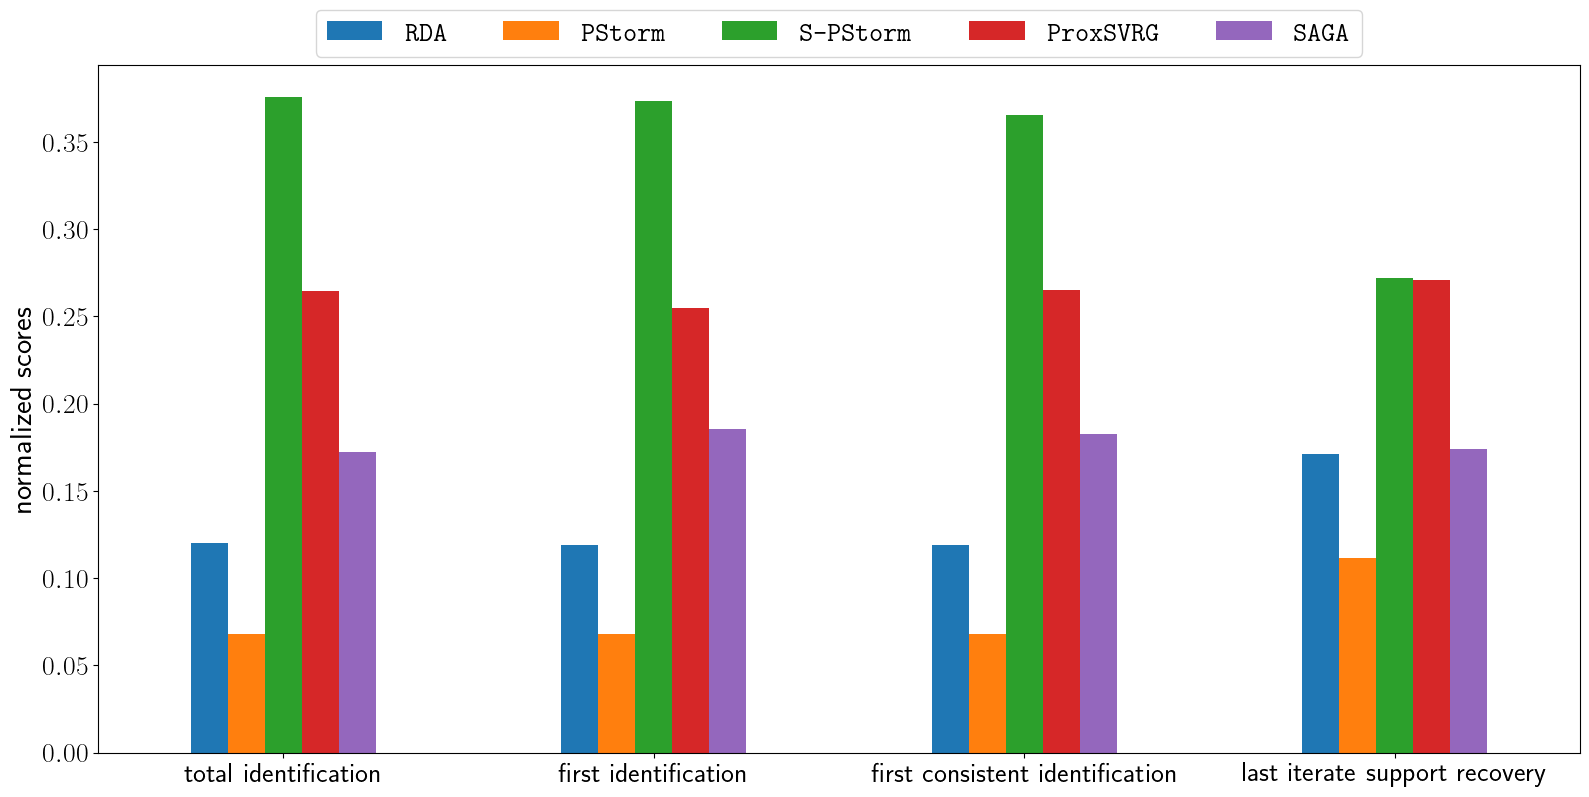

In [17]:
legend_label=[r'$\texttt{RDA}$', r'$\texttt{PStorm}$', r'$\texttt{S-PStorm}$', r'$\texttt{ProxSVRG}$', r'$\texttt{SAGA}$']
plot_df = plot_df[['RDA', 'PStorm',	'SPStorm', 'ProxSVRG', 'ProxSAGA']]
ax = plot_df.plot.bar(rot=0, figsize=(16, 8), fontsize=20)
L=ax.legend(legend_label, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(solvers), fancybox=True, prop={'size': 20, 'family':'monospace'})
plt.ylabel('normalized scores', fontdict={'size': 22})
plt.tight_layout(w_pad=0)
plt.savefig('./figs/supp_id_ipg_logit_chain.pdf', dpi=100)

In [18]:
def identity(x):
    return str(x)
def rm_underscore(x):
    return "-".join(x.split("_"))
# solvers=["ProxSVRG", "ProxSAGA", "RDA", "PStorm", "SPStorm"]

In [19]:
metric = 'total_id'
cols = []
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_ = df[cols]
all_failed_index = df_.isin([np.nan]).all(1)
all_failed_count = np.sum(all_failed_index)
print(f"All failed in {all_failed_count} / {df_.shape[0]} cases\n\n")
df_valid = df[~all_failed_index][['problem_id']+cols]
df_print = df_valid.rename(columns={
                         "problem_id": "instance",
                         "ProxSVRG_total_id": "\proxsvrg{}", 
                         "ProxSAGA_total_id": "\saga{}", 
                         "RDA_total_id": "\rda{}", 
                         "PStorm_total_id": "\pstorm{}",
                         "SPStorm_total_id": "\spstorm"})
print(df_print.to_latex(index=False, caption="Total Number of Support Identificaiton", label="tab:total_id", escape=False, formatters=[rm_underscore, identity, identity, identity, identity, identity]))

All failed in 0 / 60 cases


\begin{table}
\centering
\caption{Total Number of Support Identificaiton}
\label{tab:total_id}
\begin{tabular}{lrrrrr}
\toprule
             instance & \rda{} & \pstorm{} & \spstorm & \proxsvrg{} & \saga{} \\
\midrule
       a9a-0.1-10-0.1 &  500.0 &     348.0 &    499.0 &       498.0 &   499.0 \\
       a9a-0.1-10-0.2 &    NaN &       NaN &    488.0 &       478.0 &   488.0 \\
       a9a-0.1-10-0.3 &  498.0 &     310.0 &    499.0 &       498.0 &   499.0 \\
      a9a-0.1-100-0.1 &  500.0 &     500.0 &    500.0 &       500.0 &   500.0 \\
      a9a-0.1-100-0.2 &  500.0 &     496.0 &    500.0 &       500.0 &   500.0 \\
      a9a-0.1-100-0.3 &  500.0 &     500.0 &    500.0 &       500.0 &   500.0 \\
      a9a-0.01-10-0.1 &  373.0 &       NaN &    486.0 &       472.0 &   486.0 \\
      a9a-0.01-10-0.2 &  460.0 &       NaN &    490.0 &       482.0 &   491.0 \\
      a9a-0.01-10-0.3 &  497.0 &       NaN &    496.0 &       492.0 &   495.0 \\
     a9a-0.01-100-0.1 & 

/tmp/ipykernel_276169/2727921976.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_print.to_latex(index=False, caption="Total Number of Support Identificaiton", label="tab:total_id", escape=False, formatters=[rm_underscore, identity, identity, identity, identity, identity]))


In [20]:
metric = 'first_id'
cols = []
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_ = df[cols]
df_valid = df[~all_failed_index][['problem_id']+cols]
df_print = df_valid.rename(columns={
                         "problem_id": "instance",
                         "ProxSVRG_first_id": "\proxsvrg{}", 
                         "ProxSAGA_first_id": "\saga{}", 
                         "RDA_first_id": "\rda{}", 
                         "PStorm_first_id": "\pstorm{}",
                         "SPStorm_first_id": "\spstorm"})
print(df_print.to_latex(index=False, caption="First Support Identification", label=f"tab:{metric}", escape=False, formatters=[rm_underscore, identity, identity, identity, identity, identity]))

\begin{table}
\centering
\caption{First Support Identification}
\label{tab:first_id}
\begin{tabular}{lrrrrr}
\toprule
             instance & \rda{} & \pstorm{} & \spstorm & \proxsvrg{} & \saga{} \\
\midrule
       a9a-0.1-10-0.1 &    1.0 &     153.0 &      2.0 &         3.0 &     2.0 \\
       a9a-0.1-10-0.2 &    NaN &       NaN &     13.0 &        23.0 &     2.0 \\
       a9a-0.1-10-0.3 &    3.0 &     191.0 &      2.0 &         3.0 &     2.0 \\
      a9a-0.1-100-0.1 &    1.0 &       1.0 &      1.0 &         1.0 &     1.0 \\
      a9a-0.1-100-0.2 &    1.0 &       5.0 &      1.0 &         1.0 &     1.0 \\
      a9a-0.1-100-0.3 &    1.0 &       1.0 &      1.0 &         1.0 &     1.0 \\
      a9a-0.01-10-0.1 &  127.0 &       NaN &     15.0 &        29.0 &    15.0 \\
      a9a-0.01-10-0.2 &   38.0 &       NaN &     11.0 &        19.0 &    10.0 \\
      a9a-0.01-10-0.3 &    4.0 &       NaN &      5.0 &         9.0 &     6.0 \\
     a9a-0.01-100-0.1 &    1.0 &      19.0 &      1.0 &        

/tmp/ipykernel_276169/1062494875.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_print.to_latex(index=False, caption="First Support Identification", label=f"tab:{metric}", escape=False, formatters=[rm_underscore, identity, identity, identity, identity, identity]))


In [21]:
metric = 'first_cst_id'
cols = []
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_ = df[cols]
df_valid = df[~all_failed_index][['problem_id']+cols]
df_print = df_valid.rename(columns={
                         "problem_id": "instance",
                         f"ProxSVRG_{metric}": "\proxsvrg{}", 
                         f"ProxSAGA_{metric}": "\saga{}", 
                         f"RDA_{metric}": "\rda{}", 
                         f"PStorm_{metric}": "\pstorm{}",
                         f"SPStorm_{metric}": "\spstorm{}"})
print(df_print.to_latex(index=False, caption="First Consistent Support Identification", label=f"tab:{metric}", escape=False, formatters=[rm_underscore, identity, identity, identity, identity, identity]))

\begin{table}
\centering
\caption{First Consistent Support Identification}
\label{tab:first_cst_id}
\begin{tabular}{lrrrrr}
\toprule
             instance & \rda{} & \pstorm{} & \spstorm{} & \proxsvrg{} & \saga{} \\
\midrule
       a9a-0.1-10-0.1 &    1.0 &     153.0 &        2.0 &         3.0 &     2.0 \\
       a9a-0.1-10-0.2 &    NaN &       NaN &       13.0 &        23.0 &    14.0 \\
       a9a-0.1-10-0.3 &    3.0 &     191.0 &        2.0 &         3.0 &     2.0 \\
      a9a-0.1-100-0.1 &    1.0 &       1.0 &        1.0 &         1.0 &     1.0 \\
      a9a-0.1-100-0.2 &    1.0 &       5.0 &        1.0 &         1.0 &     1.0 \\
      a9a-0.1-100-0.3 &    1.0 &       1.0 &        1.0 &         1.0 &     1.0 \\
      a9a-0.01-10-0.1 &  129.0 &       NaN &       15.0 &        29.0 &    15.0 \\
      a9a-0.01-10-0.2 &   42.0 &       NaN &       11.0 &        19.0 &    10.0 \\
      a9a-0.01-10-0.3 &    4.0 &       NaN &        5.0 &         9.0 &     6.0 \\
     a9a-0.01-100-0.1 &    1

/tmp/ipykernel_276169/554932558.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_print.to_latex(index=False, caption="First Consistent Support Identification", label=f"tab:{metric}", escape=False, formatters=[rm_underscore, identity, identity, identity, identity, identity]))


In [22]:
metric = 'last_nz'
cols = []
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_ = df[cols]
df_valid = df[~all_failed_index][['problem_id', 'nz_gt']+cols]
df_print = df_valid.rename(columns={
                         "problem_id": "instance",
                         "nz_gt": "nz REF",
                         f"ProxSVRG_{metric}": "\proxsvrg{}", 
                         f"ProxSAGA_{metric}": "\saga{}", 
                         f"RDA_{metric}": "\rda{}", 
                         f"PStorm_{metric}": "\pstorm{}",
                         f"SPStorm_{metric}": "\spstorm{}"})
print(df_print.to_latex(index=False, caption="Last Iterate Support Recovery", label=f"tab:{metric}", escape=False, formatters=[rm_underscore, identity, identity, identity, identity, identity, identity]))

\begin{table}
\centering
\caption{Last Iterate Support Recovery}
\label{tab:last_nz}
\begin{tabular}{lrrrrrr}
\toprule
             instance &   nz REF &   \rda{} & \pstorm{} & \spstorm{} & \proxsvrg{} & \saga{} \\
\midrule
       a9a-0.1-10-0.1 &     12.0 &     12.0 &      12.0 &       12.0 &        12.0 &    12.0 \\
       a9a-0.1-10-0.2 &     11.0 &     10.0 &      10.0 &       11.0 &        11.0 &    11.0 \\
       a9a-0.1-10-0.3 &     16.0 &     16.0 &      16.0 &       16.0 &        16.0 &    16.0 \\
      a9a-0.1-100-0.1 &      1.0 &      1.0 &       1.0 &        1.0 &         1.0 &     1.0 \\
      a9a-0.1-100-0.2 &      1.0 &      1.0 &       1.0 &        1.0 &         1.0 &     1.0 \\
      a9a-0.1-100-0.3 &      0.0 &      0.0 &       0.0 &        0.0 &         0.0 &     0.0 \\
      a9a-0.01-10-0.1 &      7.0 &      7.0 &       4.0 &        7.0 &         7.0 &     7.0 \\
      a9a-0.01-10-0.2 &      8.0 &      8.0 &       5.0 &        8.0 &         8.0 &     8.0 \\
      a9

/tmp/ipykernel_276169/3069200281.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_print.to_latex(index=False, caption="Last Iterate Support Recovery", label=f"tab:{metric}", escape=False, formatters=[rm_underscore, identity, identity, identity, identity, identity, identity]))


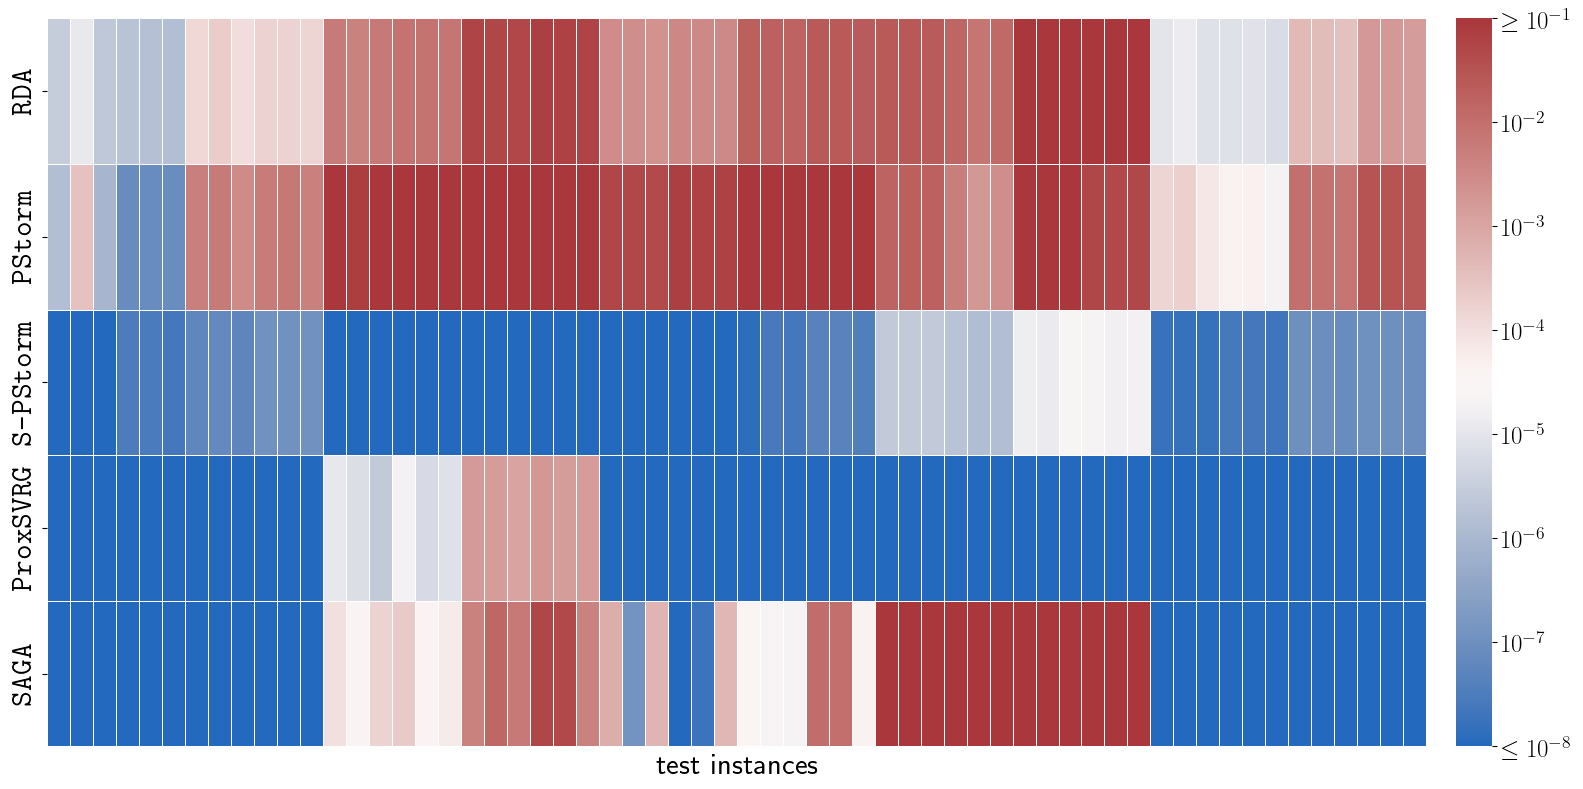

In [23]:
metric = 'best_F'
cols = ['F_gt']
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_Fval = df[cols].fillna(1e18)
df_Fval['problem_id'] = df['problem_id']
for solver in solvers:
    df_Fval[f'{solver}_{metric}_diff'] = np.abs(df_Fval[f'{solver}_{metric}'] - df_Fval['F_gt']) /  df_Fval['F_gt']
cols = []    
for solver in solvers:
    cols += [f'{solver}_{metric}_diff']
df_Fval_diff = df_Fval[cols]
heat_map_data = df_Fval_diff.to_numpy().T
heat_map_data_log = np.log10(heat_map_data+1e-18)

plt.figure(figsize=(16,8))
ax = sns.heatmap(heat_map_data_log, linewidths=.5, cmap= sns.color_palette("vlag", as_cmap=True), vmin=-8, vmax=-1, cbar_kws={"fraction": 0.05, 'pad':0.02})
ax.set_yticklabels(legend_label, fontsize=22)
ax.set_xlabel('test instances', fontsize=22)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
# ax.set_title('F_{best} - F^*', fontsize=15)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-8, -7, -6,  -5, -4, -3, -2, -1])
cbar.set_ticklabels([r'$\leq 10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$\geq 10^{-1}$'])
cbar.ax.tick_params(labelsize=18) 
plt.tight_layout(w_pad=0)
plt.savefig('./figs/Fval_diff_ipg_logit_chain.pdf', dpi=100)

In [24]:
df_Fval_diff

,RDA_best_F_diff,PStorm_best_F_diff,SPStorm_best_F_diff,ProxSVRG_best_F_diff,ProxSAGA_best_F_diff
0,0.000003,1.442156e-06,3.038143e-09,2.183440e-16,0.000000e+00
1,0.000012,3.202406e-04,1.029507e-08,0.000000e+00,0.000000e+00
2,0.000002,8.987261e-07,9.104015e-10,0.000000e+00,0.000000e+00
3,0.000002,8.027810e-08,2.940959e-08,1.156133e-16,0.000000e+00
4,0.000002,8.150131e-08,2.865819e-08,0.000000e+00,0.000000e+00
5,0.000001,8.628010e-08,2.284551e-08,0.000000e+00,0.000000e+00
6,0.000133,4.996412e-03,6.166658e-08,1.509910e-16,0.000000e+00
7,0.000202,5.985981e-03,6.713850e-08,2.996775e-16,0.000000e+00
8,0.000105,2.969198e-03,5.734721e-08,1.476995e-16,0.000000e+00
9,0.000161,5.680926e-03,1.127490e-07,0.000000e+00,0.000000e+00


# Convergence Progress

In [25]:
def collect_one_run(actual_seed, dataset, lam_shrink, chain_grpsize, chain_overlap_ratio, 
                    solvers=["ProxSVRG", "ProxSAGA", "RDA", "PStorm", "SPStorm"]):
    all_solver_stats = {}
    for solver in solvers:
        filename = gen_path(solver, regularizer='NatOG', actual_seed=actual_seed, 
                            dataset=dataset, lam_shrink=lam_shrink, chain_grpsize=chain_grpsize, chain_overlap_ratio=chain_overlap_ratio)
        info = np.load(filename,  allow_pickle=True).item()
        all_solver_stats[solver] = {}
        all_solver_stats[solver]['num_data_pass'] = info['num_data_pass']
        all_solver_stats[solver]['F_seq'] = np.array(info['F_seq'])
        all_solver_stats[solver]['nz_seq'] = np.array(info['nz_seq'])
        all_solver_stats[solver]['x_seq'] = np.array(info['x_seq'])        
        all_solver_stats[solver]['grad_error_seq'] = np.array(info['grad_error_seq'])
        all_solver_stats[solver]['time_seq'] = info['time_seq']
        all_solver_stats[solver]['total_bak_seq'] = info['total_bak_seq']
        all_solver_stats[solver]['inner_its_seq'] = info['inner_its_seq']        
        all_solver_stats[solver]['xend'] = info['xend']
    problem_id = f"{dataset}_{lam_shrink}_{chain_grpsize}_{chain_overlap_ratio}"
    return problem_id, all_solver_stats

In [26]:
# all_solver_stats = collect_one_run(actual_seed=2023, dataset='a9a', lam_shrink=0.1, chain_grpsize=10, chain_overlap_ratio=0.1)[1]

In [28]:
def plot_convergence(actual_seed = 2023, dataset='a9a', lam_shrink=0.1,
                     chain_grpsize = 10, chain_overlap_ratio=0.1,
                     xval_end = 500,  support_end = 500,  grad_erro_end = 500,
                     exclude=None, result=False, max_epoch=500, 
                     selected_solver_per_instance_dict=selected_solver_per_instance_dict,
                     gt_dict=gt_dict):
   
    if exclude is None:
        solvers_original_order = ["ProxSVRG", "ProxSAGA","RDA", "PStorm", "SPStorm"]
    else:
        solvers_original_order = ["ProxSVRG", "RDA", "PStorm", "SPStorm"]
    problem_id, all_solver_stats = collect_one_run(actual_seed, dataset, lam_shrink, chain_grpsize, chain_overlap_ratio,
                                                  solvers=solvers_original_order)
    
    reference_solver = solvers_original_order[selected_solver_per_instance_dict[problem_id]]
    print(f'reference solver:{reference_solver}')
    info = all_solver_stats[reference_solver]
    Fbest_idx = np.nanargmin(info['F_seq'])
    xstar = info['x_seq'][Fbest_idx]
    x_seq_distance = {}
    inner_seq = {}
    if exclude is None:
        solvers = ["RDA", "PStorm", "SPStorm", "ProxSVRG", "ProxSAGA"]
        legend_label=[r'$\texttt{RDA}$', r'$\texttt{PStorm}$', r'$\texttt{S-PStorm}$', r'$\texttt{ProxSVRG}$', r'$\texttt{SAGA}$']
    else:
        solvers = ["RDA", "PStorm", "SPStorm", "ProxSVRG"]
        legend_label=[r'$\texttt{RDA}$', r'$\texttt{PStorm}$', r'$\texttt{S-PStorm}$', r'$\texttt{ProxSVRG}$']
    for solver in solvers:
        x_seq = all_solver_stats[solver]['x_seq']
        temp = [0] * len(x_seq)
        for i in range(len(x_seq)):
            temp[i] = np.linalg.norm((x_seq[i] - xstar).toarray())
        x_seq_distance[solver] = temp
        inner_seq[solver] = all_solver_stats[solver]['total_bak_seq'] + all_solver_stats[solver]['inner_its_seq'] 

    # fig, axs = plt.subplots(1, 4, figsize=(48,6))
    fig, axs = plt.subplots(1, 3, figsize=(36,6))
    for i, solver in enumerate(solvers):
        num_data_pass = all_solver_stats[solver]['num_data_pass']
        xdist_seq = x_seq_distance[solver][:-1]
        inner_workload = inner_seq[solver][:-1]
        nz_seq = all_solver_stats[solver]['nz_seq'][:-1]
        grad_error_seq = all_solver_stats[solver]['grad_error_seq'][1:]
        # if solver == 'RDA':
        #     print(min(xdist_seq))
        axs[0].plot(range(1, num_data_pass+1)[:min(num_data_pass,xval_end,len(xdist_seq))], 
                    xdist_seq[:min(num_data_pass,xval_end,len(xdist_seq))], label=legend_label[i])
        axs[1].plot(range(1, num_data_pass+1)[:min(num_data_pass,grad_erro_end,len(grad_error_seq))], 
                    grad_error_seq[:min(num_data_pass,grad_erro_end, len(grad_error_seq))], label=legend_label[i])
        axs[2].plot(range(1, num_data_pass+1)[:min(num_data_pass,support_end,len(nz_seq))], 
                    nz_seq[:min(num_data_pass,support_end,len(nz_seq))], label=legend_label[i])
        # axs[3].plot(range(1, num_data_pass+1)[:min(num_data_pass,xval_end,len(inner_workload))], 
        #             inner_workload[:min(num_data_pass,xval_end,len(inner_workload))], label=legend_label[i])
    # xref = np.arange(1,max_epoch+1) 
    # yref = np.sqrt(np.log(xref)/xref)
    # yref[0] = 1.0
    # axs[0].plot(range(1, num_data_pass+1)[:min(num_data_pass,xval_end)], yref[:min(num_data_pass,xval_end)], 'k-.', label=r"$\sqrt{\log k/k}$")      
    # axs[1].plot(range(1, num_data_pass+1)[:min(num_data_pass,xval_end)], 0.1 * yref[:min(num_data_pass,xval_end)], 'k-.', label=r"$\sqrt{\log k/k}$")    
    axs[2].axhline(gt_dict[problem_id]['nz_gt'], color='black', linewidth=2, alpha=0.5)    


    axs[0].set_xlabel('number of data pass', fontsize=20)
    axs[0].set_ylabel(r'$\|x_k-x^*\|$', fontsize=20)
    axs[0].set_yscale('log')
    axs[0].tick_params(axis='both', which='major', labelsize=20)
    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fancybox=True, prop={'size': 16})
    axs[0].tick_params(axis='both', which='major', labelsize=20)

    axs[1].set_xlabel('number of data pass', fontsize=20)
    axs[1].set_ylabel('error in the gradient estimate', fontsize=20)
    axs[1].set_yscale('log')
    axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fancybox=True, prop={'size': 16})
    axs[1].tick_params(axis='both', which='major', labelsize=20)

    axs[2].set_xlabel('number of data pass', fontsize=20)
    axs[2].set_ylabel('number of zero groups', fontsize=20)
    axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fancybox=True, prop={'size': 16})
    axs[2].tick_params(axis='both', which='major', labelsize=20)
    
    # axs[3].set_xlabel('number of data pass', fontsize=20)
    # axs[3].set_ylabel('\#inner iters + \# backtracking', fontsize=20)
    # axs[3].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fancybox=True, prop={'size': 16})
    # axs[3].tick_params(axis='both', which='major', labelsize=20)

    fig.tight_layout()   
    plt.savefig(f'./figs/convergence_{dataset}_{lam_shrink}_{chain_grpsize}_{chain_overlap_ratio}_logit_chain.pdf', dpi=100)
    if result:
        return x_seq_distance

reference solver:ProxSVRG


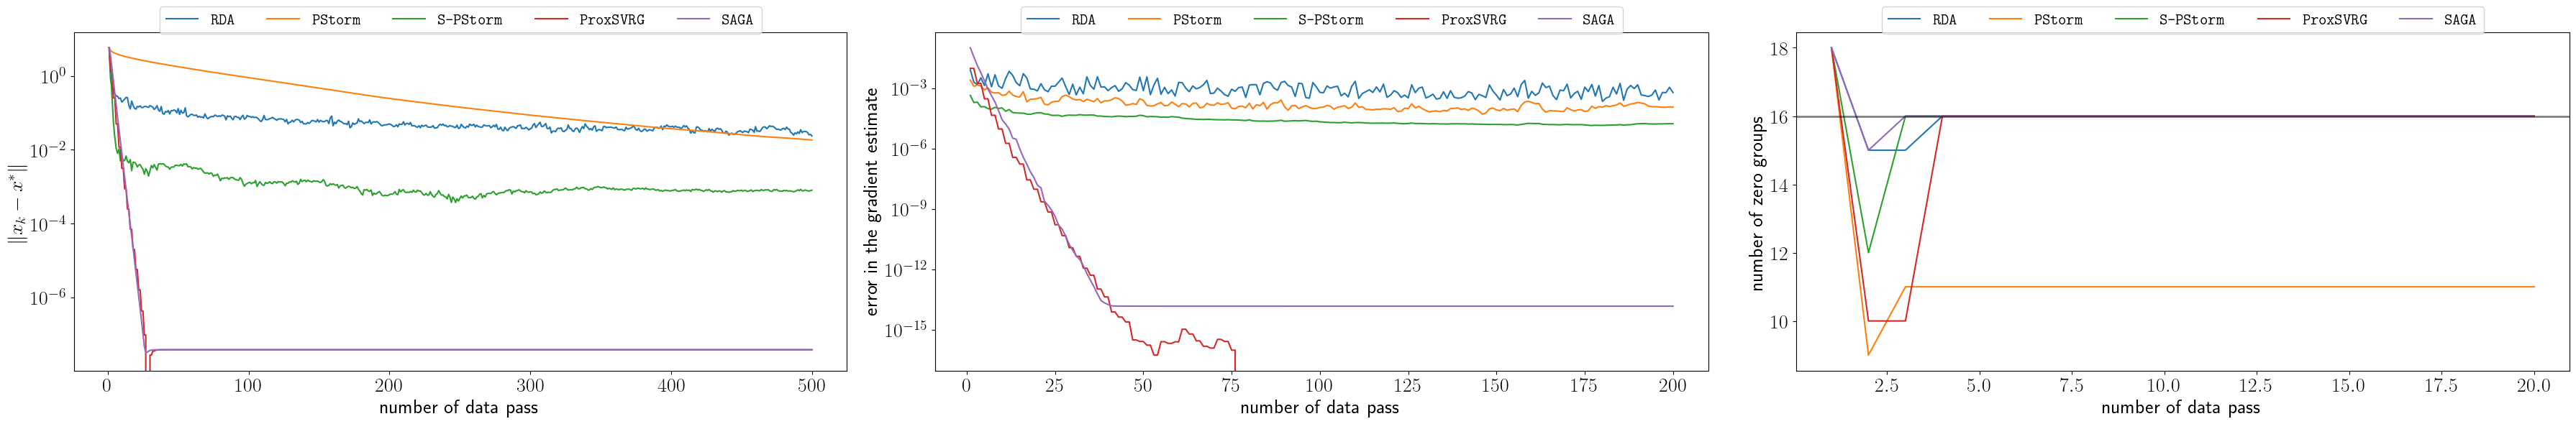

In [29]:
plot_convergence(actual_seed = 2023, dataset='a9a', lam_shrink=0.1,
                 chain_grpsize = 10, chain_overlap_ratio=0.3,
                  xval_end = 500,  support_end = 20,  grad_erro_end = 200)

reference solver:ProxSVRG


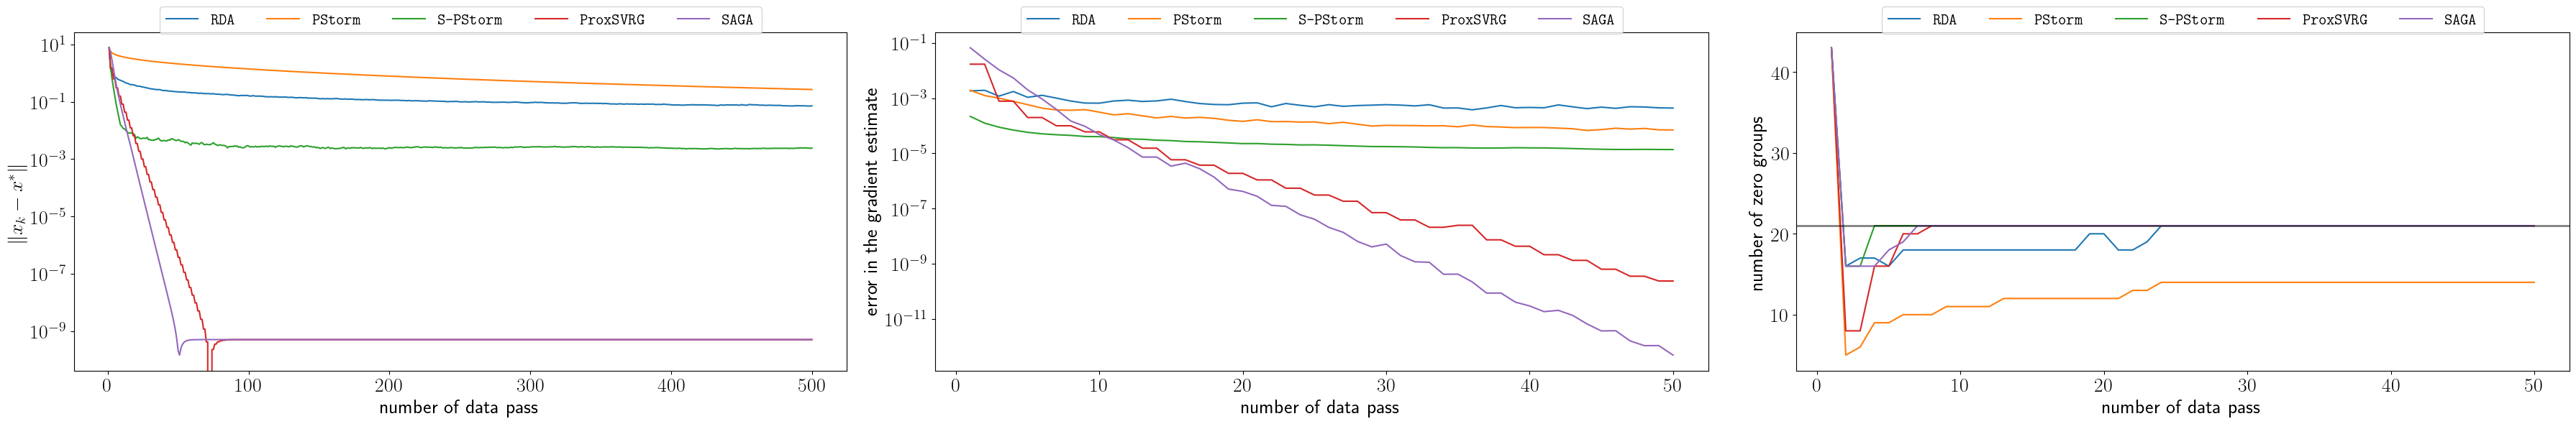

In [30]:
plot_convergence(actual_seed = 2023, dataset='w8a', lam_shrink=0.1,
                 chain_grpsize = 10, chain_overlap_ratio=0.3,
                  xval_end = 500,  support_end = 50,  grad_erro_end = 50)

reference solver:SPStorm


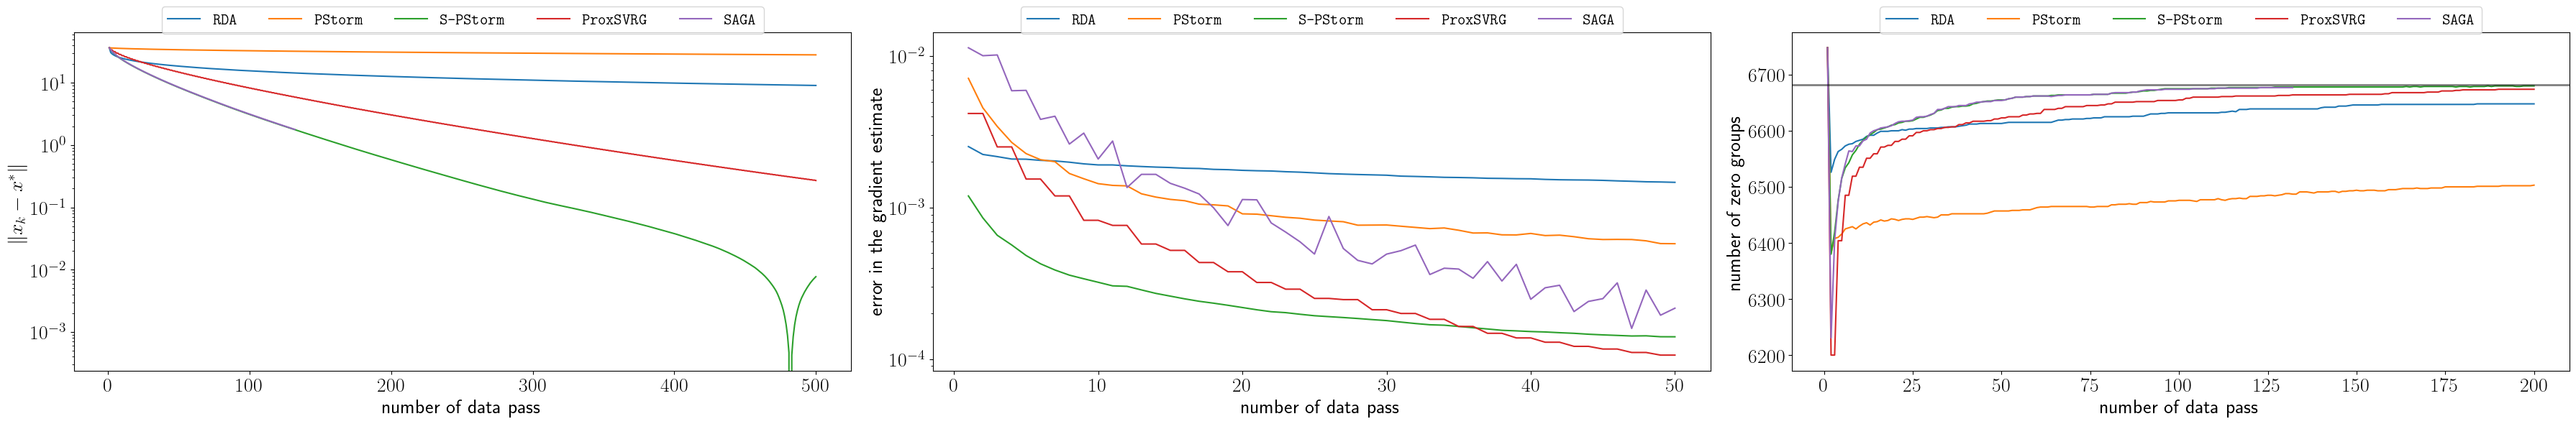

In [31]:
plot_convergence(actual_seed = 2023, dataset='rcv1', lam_shrink=0.1,
                 chain_grpsize = 10, chain_overlap_ratio=0.3,
                  xval_end = 500,  support_end = 200,  grad_erro_end = 50)

reference solver:ProxSVRG


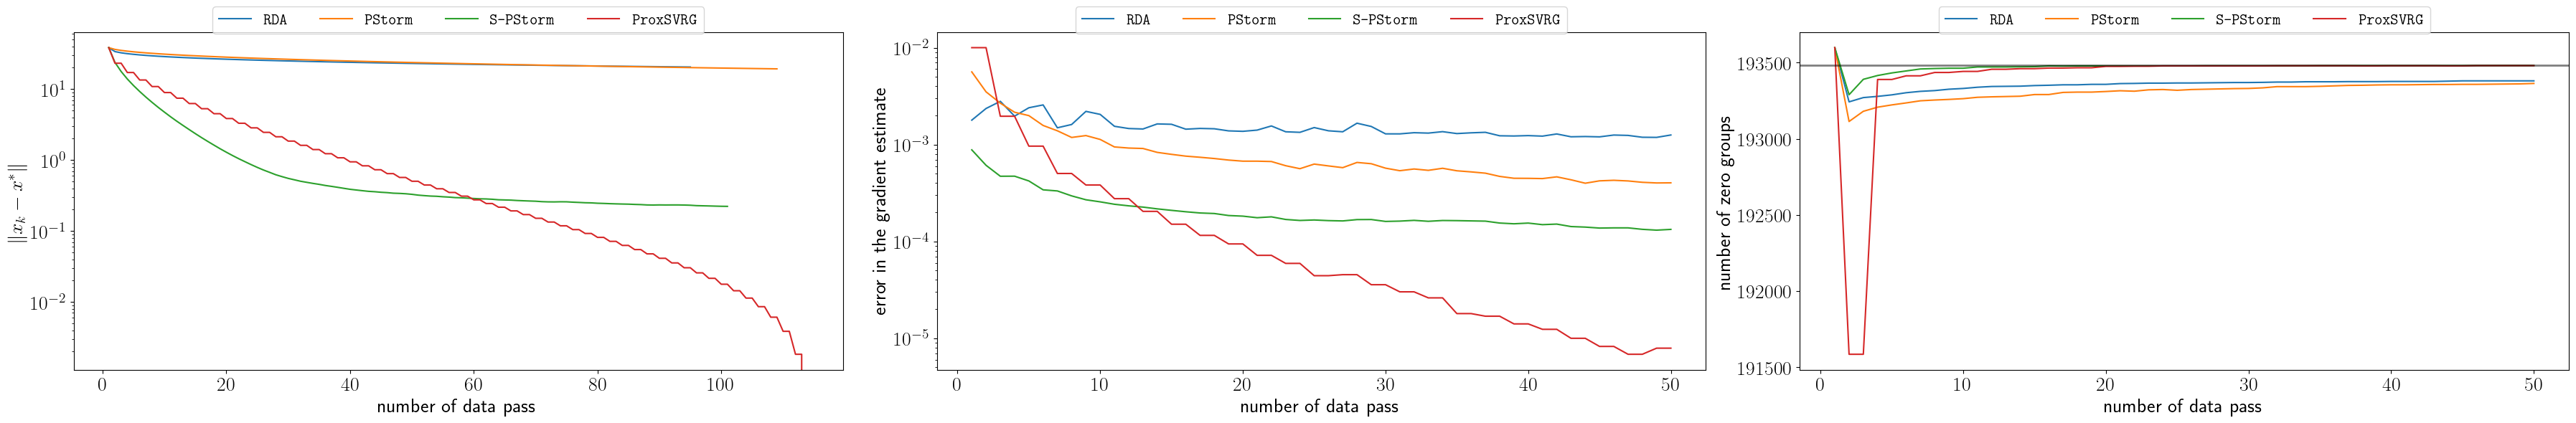

In [32]:
plot_convergence(actual_seed = 2023, dataset='news20', lam_shrink=0.1,
                 chain_grpsize = 10, chain_overlap_ratio=0.3,
                  xval_end = 500,  support_end = 50,  grad_erro_end = 50, exclude=True)

reference solver:ProxSVRG


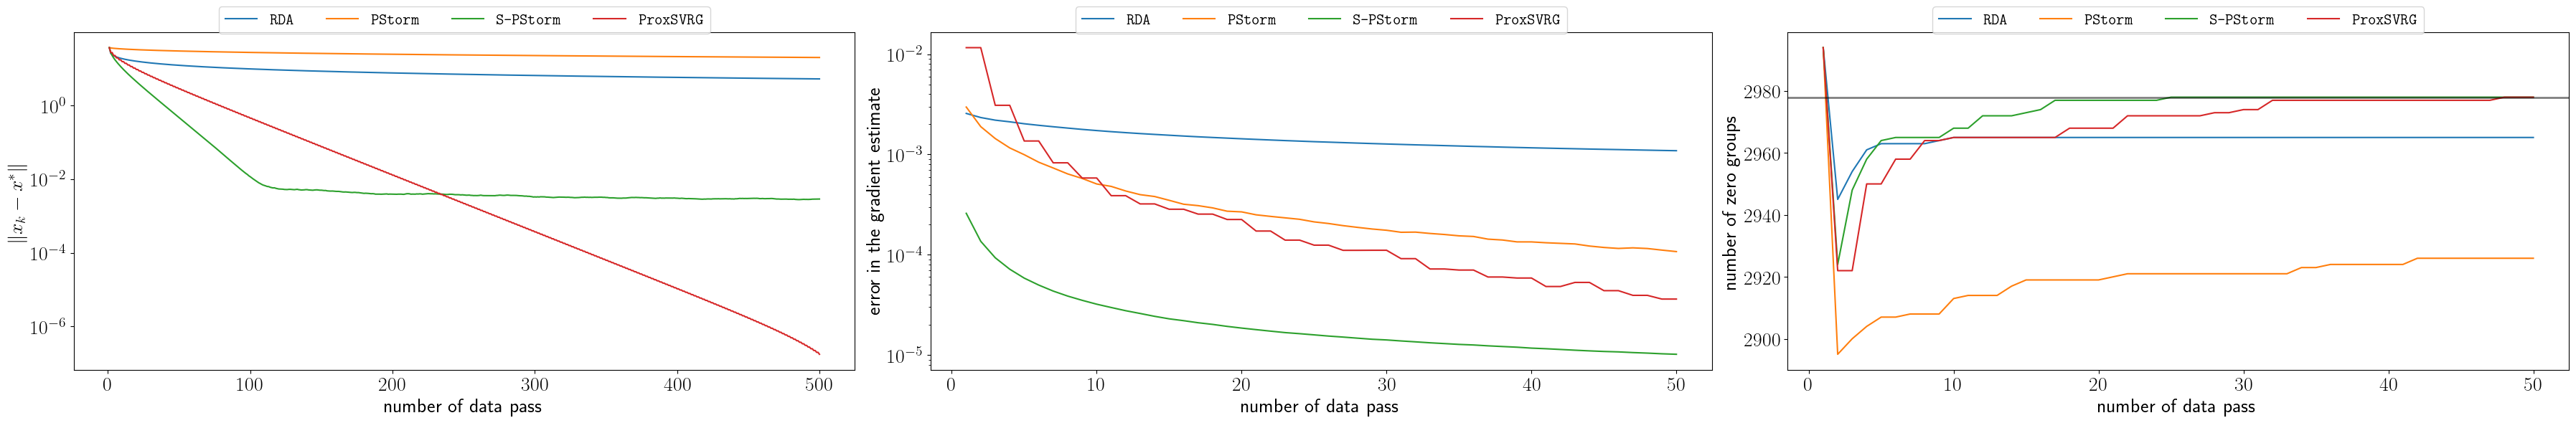

In [33]:
plot_convergence(actual_seed = 2023, dataset='real-sim', lam_shrink=0.1,
                 chain_grpsize = 10, chain_overlap_ratio=0.3,
                  xval_end = 500,  support_end = 50,  grad_erro_end = 50, exclude=True)